# MBCn implementation
## I. Pre-processing
### I.1 Libraries

In [3]:
library(R6)
library(ggplot2)
library(gridExtra)
library(SBCK)

### II.2 Functions

In [37]:
plot_2d = function( XYZ )
{
	X0 = XYZ$X0
	X1 = XYZ$X1
	Y0 = XYZ$Y0
	Z0 = XYZ$Z0
	Z1 = XYZ$Z1
	
	g0 = ggplot2::ggplot( data.frame( x = X0[,1] , y = X0[,2] ) , ggplot2::aes( x = x , y = y ) )
	g0 = g0 + ggplot2::geom_point( color = "red" )
	g0 = g0 + ggplot2::ggtitle( "X0" )
	
	g1 = ggplot2::ggplot( data.frame( x = Y0[,1] , y = Y0[,2] ) , ggplot2::aes( x = x , y = y ) )
	g1 = g1 + ggplot2::geom_point( color = "blue" )
	g1 = g1 + ggplot2::ggtitle( "Y0" )
	
	g2 = ggplot2::ggplot()
	if( !is.null(Z0) )
	{
		g2 = ggplot2::ggplot( data.frame( x = Z0[,1] , y = Z0[,2] ) , ggplot2::aes( x = x , y = y ) )
		g2 = g2 + ggplot2::geom_point( color = "green" )
		g2 = g2 + ggplot2::ggtitle( "Z0" )
	}
	
	g3 = ggplot2::ggplot( data.frame( x = X1[,1] , y = X1[,2] ) , ggplot2::aes( x = x , y = y ) )
	g3 = g3 + ggplot2::geom_point( color = "red" )
	g3 = g3 + ggplot2::ggtitle( "X1" )
	
	g4 = ggplot2::ggplot()
	
	g5 = ggplot2::ggplot()
	if( !is.null(Z1) )
	{
		g5 = ggplot2::ggplot( data.frame( x = Z1[,1] , y = Z1[,2] ) , ggplot2::aes( x = x , y = y ) )
		g5 = g5 + ggplot2::geom_point( color = "green" )
		g5 = g5 + ggplot2::ggtitle( "Z1" )
	}
	
	g = gridExtra::grid.arrange( g0 , g1 , g2 , g3 , g4 , g5 , ncol = 3 , nrow = 2 )
}

### I.2 Dataset

In [38]:
XY = SBCK::dataset_bimodal_reverse_dd(2000)
Y0 = XY$Y0
X0 = XY$X0
X1 = XY$X1

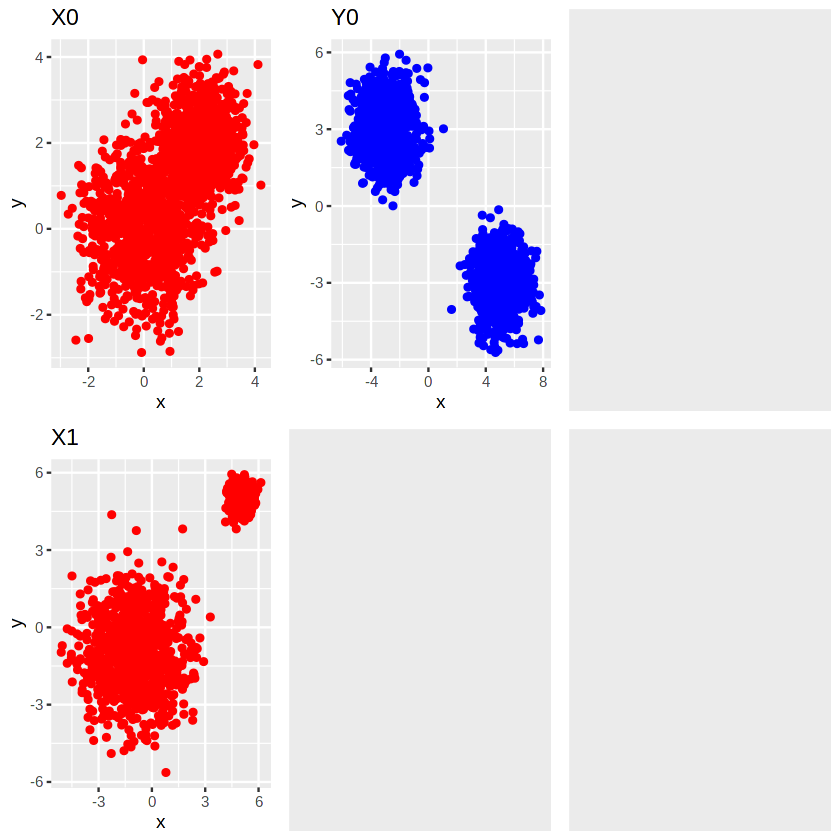

In [39]:
plot_2d( list( X0 = X0 , Y0 = Y0 , X1 = X1 ) )

## II. Quantile Delta Mapping

In [209]:
QDM = R6::R6Class( "QDM" ,
	
	public = list(
	
	###############
	## Arguments ##
	###############
	
	#################
	## Constructor ##
	#################
	
	initialize = function( delta = "additive" , ... )
	{
		## Initialize delta method
		if( class(delta) == "list" )
		{
			private$delta_method = delta[[1]]
			private$idelta_method = delta[[2]]
		}
		else if( delta == "multiplicative" )
		{
			private$delta_method  = private$mult
			private$idelta_method = private$div
		}
		else
		{
			private$delta_method  = private$add
			private$idelta_method = private$sub
		}
		
		private$qm_args = list(...)
	},
	
	fit = function( Y0 , X0 , X1 )
	{
		if( !is.matrix(Y0) ) Y0 = base::matrix( Y0 , ncol = 1 , nrow = length(Y0) )
		if( !is.matrix(X0) ) X0 = base::matrix( X0 , ncol = 1 , nrow = length(X0) )
		if( !is.matrix(X1) ) X1 = base::matrix( X1 , ncol = 1 , nrow = length(X1) )
		
		## Fit calibration part
		private$qmX0Y0 = base::do.call( QM$new , private$qm_args )
		private$qmX0Y0$fit( Y0 , X0 )
		
		## Fit delta
		qmX1X0 = base::do.call( QM$new , private$qm_args )
		qmX1X0$fit( X0 , X1 )
		private$delta = private$idelta_method( X1 , qmX1X0$predict(X1) )
		
		## Fit projection part
		private$qmX1Y0 = base::do.call( QM$new , private$qm_args )
		private$qmX1Y0$fit( Y0 , X1 )
	},
	
	predict = function( X1 , X0 = NULL )
	{
		if( !is.null(X0) && !is.matrix(X0) ) X0 = base::matrix( X0 , ncol = 1 , nrow = length(X0) )
		if( !is.matrix(X1) ) X1 = base::matrix( X1 , ncol = 1 , nrow = length(X1) )
		
		Z1 = private$delta_method( private$qmX1Y0$predict(X1) , private$delta )
		if( !is.null(X0) )
		{
			Z0 = private$qmX0Y0$predict(X0)
			return( list( Z1 = Z1 , Z0 = Z0 ) )
		}
		return(Z1)
	}
	
	
	),
	
	private = list(
	
	###############
	## Arguments ##
	###############
	
	delta_method  = NULL,
	idelta_method = NULL,
	delta = NULL,
	qm_args = NULL,
	qmX0Y0 = NULL,
	qmX1Y0 = NULL,
	
	
	#############
	## Methods ##
	#############
	
	add = function(x,y)
	{ 
		return( x + y )
	},
	
	mult = function(x,y)
	{ 
		return( x * y )
	},
	
	sub = function(x,y)
	{ 
		return( x - y )
	},
	
	div = function(x,y)
	{ 
		return( x / y )
	}
		
	)
)

In [41]:
qdm = QDM$new()
qdm$fit( Y0 , X0 , X1 )
Z = qdm$predict(X1,X0)
Z0 = Z$Z0
Z1 = Z$Z1

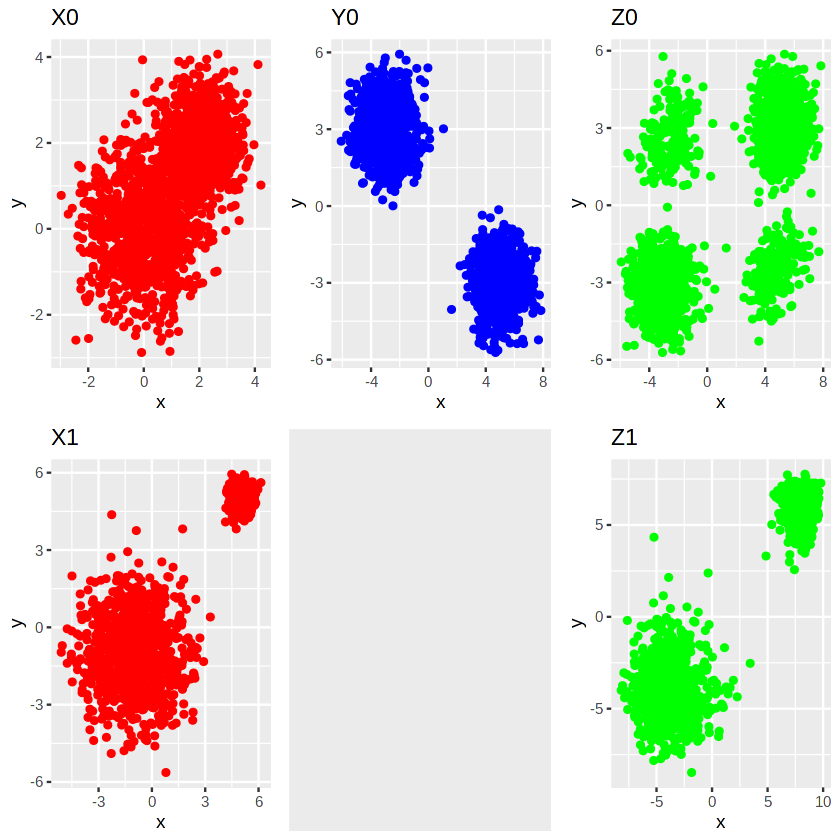

In [42]:
plot_2d( list( X0 = X0 , Y0 = Y0 , X1 = X1 , Z0 = Z0 , Z1 = Z1 ) )

## III. MBCn
### III.1 Orthogonal matrix generator

In [101]:
rorthogonal_group = function( d , n = 1 )
{
	rot = array( stats::runif( d * d * n ) , dim = base::c( d , d , n ) )
	for( i in 1:n )
	{
		QR = base::qr( rot[,,i] )
		Q  = base::qr.Q(QR)
		R  = base::diag(base::qr.R(QR))
		R  = base::diag( R / base::abs(R) )
		rot[,,i] = Q %*% R
	}
	return(rot)
}

### III.2 Stopping criteria

In [161]:
SlopeStoppingCriteria = R6::R6Class( "SlopeStoppingCriteria" ,
	
	public = list(
	
	################
	## Parameters ##
	################
	
	minit = NULL,
	maxit = NULL,
	nit   = NULL,
	tol   = NULL,
	stop  = NULL,
	criteria = NULL,
	slope = NULL,
	
	
	#################
	## Constructor ##
	#################
	
	initialize = function( minit , maxit , tol )
	{
		self$minit = minit
		self$maxit = maxit
		self$tol = tol
		self$nit = 1
		self$stop = FALSE
		self$criteria = numeric(maxit)
		self$slope = numeric(maxit)
	},
	
	reset = function()
	{
		self$nit = 1
		self$stop = FALSE
		self$criteria = numeric(maxit)
		self$slope = numeric(maxit)
	},
	
	append = function(value)
	{
		self$criteria[self$nit] = value
		if( self$nit >= 2 )
		{
			x = 1:self$nit
			y = self$criteria[1:self$nit]
			lm = stats::lm( y ~ x )
			self$slope[self$nit-1] = as.vector(lm$coefficients[2])
		}
		self$stop = (self$nit >= self$minit) && (self$nit >= self$maxit || base::abs(self$slope[self$nit-1]) < self$tol)
		self$nit = self$nit + 1
	}
	
	)
)

In [163]:
stop_slope = SlopeStoppingCriteria$new( 20 , 500 , 1e-3 )
x = 0
while(!stop_slope$stop)
{
	stop_slope$append(base::exp(-x))
	x = x + 0.1
}
print(stop_slope$nit)

[1] 242


### III.3 MBCn

In [239]:
MBCn = R6::R6Class( "MBCn" ,
	
	public = list(
	
	###############
	## Arguments ##
	###############
	
	n_features = NULL,
	bc = NULL,
	metric = NULL,
	iter_slope = NULL,
	bc_params = NULL,
	ortho_mat = NULL,
	tips = NULL,
	lbc = NULL,
	
	#################
	## Constructor ##
	#################
	
	initialize = function( bc = QDM , metric = wasserstein , stopping_criteria = SlopeStoppingCriteria , stopping_criteria_params = list( minit = 20 , maxit = 500 , tol = 1e-3 ) , ... )
	{
		self$n_features = NULL
		self$bc = bc
		self$metric = metric
		self$iter_slope = base::do.call( stopping_criteria$new , stopping_criteria_params )
		self$bc_params = list(...)
		self$ortho_mat = NULL
		self$tips = NULL
		self$lbc = list()
	},
	
	fit = function( Y0 , X0 , X1 )
	{
		if( !is.matrix(Y0) ) Y0 = base::matrix( Y0 , ncol = 1 , nrow = length(Y0) )
		if( !is.matrix(X0) ) X0 = base::matrix( X0 , ncol = 1 , nrow = length(X0) )
		if( !is.matrix(X1) ) X1 = base::matrix( X1 , ncol = 1 , nrow = length(X1) )
		self$n_features = base::ncol(Y0)
		
		self$iter_slope$reset()
		maxit = self$iter_slope$maxit
		
		## Generate orthogonal matrix
		self$ortho_mat = rorthogonal_group( self$n_features , maxit )
		
		## Tips for performance: inverse + ortho of next in one pass
		self$tips = array( NA , dim = base::dim(self$ortho_mat) )
		for( i in 1:(maxit-1) )
			self$tips[,,i] = self$ortho_mat[,,i+1] %*% base::solve(self$ortho_mat[,,i])
		self$tips[,,maxit] = base::solve(self$ortho_mat[,,maxit])
		
		## Init loop
		Z0_o = base::t(self$ortho_mat[,,1] %*% base::t(X0))
		Z1_o = base::t(self$ortho_mat[,,1] %*% base::t(X1))
		
		## Main loop
		while(!self$iter_slope$stop)
		{
			nit = self$iter_slope$nit
			Y0_o = base::t(self$ortho_mat[,,nit] %*% base::t(Y0))
			
			bc = base::do.call( self$bc$new , self$bc_params )
			bc$fit( Y0_o , Z0_o , Z1_o )
			Z = bc$predict(Z1_o,Z0_o)
			Z1_o = Z$Z1
			Z0_o = Z$Z0
			self$lbc[[nit]] = bc
			
			self$iter_slope$append(self$metric(Z0_o,Y0_o))
			
			Z0_o = base::t(self$tips[,,nit] %*% base::t(Z0_o))
			Z1_o = base::t(self$tips[,,nit] %*% base::t(Z1_o))
		}
		
		nit = self$iter_slope$nit
		self$ortho_mat = self$ortho_mat[,,1:nit]
		self$tips = self$tips[,,1:nit]
		self$tips[,,nit] = base::solve(self$ortho_mat[,,nit]) 
		
		Z0 = base::t(self$tips[,,nit] %*% base::t(Z0_o))
		Z1 = base::t(self$tips[,,nit] %*% base::t(Z1_o))
		
		bc = base::do.call( self$bc$new , self$bc_params )
		bc$fit( Y0 , Z0 , Z1 )
		self$lbc[[nit]] = bc
	},
	
	predict = function( X1 , X0 = NULL )
	{
		if( is.null(X0) )
			return(private$predict_X1(X1))
		else
			return(private$predict_X1_X0(X1,X0))
	
	}
	
	
	),
	
	private = list(
	
	###############
	## Arguments ##
	###############
	
	
	#############
	## Methods ##
	#############
	
	predict_X1 = function(X1)
	{
		if( !is.matrix(X1) ) X1 = base::matrix( X1 , ncol = 1 , nrow = length(X1) )
		
		nit = self$iter_slope$nit
		
		Z1_o = base::t(self$ortho_mat[,,1] %*% base::t(X1))
		
		for( i in 1:(nit-1) )
		{
			Z1_o = self$lbc[[i]]$predict(Z1_o)
			Z1_o = base::t(self$tips[,,i] %*% base::t(Z1_o))
		}
		
		Z1_o = base::t(self$tips[,,nit] %*% base::t(Z1_o))
		Z1 = self$lbc[[nit]]$predict(Z1_o)
		return(Z1)
		
	},
	
	predict_X1_X0 = function(X1,X0)
	{
		if( !is.matrix(X1) ) X1 = base::matrix( X1 , ncol = 1 , nrow = length(X1) )
		if( !is.matrix(X0) ) X0 = base::matrix( X0 , ncol = 1 , nrow = length(X0) )
		
		nit = self$iter_slope$nit
		
		Z0_o = base::t(self$ortho_mat[,,1] %*% base::t(X0))
		Z1_o = base::t(self$ortho_mat[,,1] %*% base::t(X1))
		
		for( i in 1:(nit-1) )
		{
			Z = self$lbc[[i]]$predict(Z1_o,Z0_o)
			Z0_o = base::t(self$tips[,,i] %*% base::t(Z$Z0))
			Z1_o = base::t(self$tips[,,i] %*% base::t(Z$Z1))
		}
		
		Z0_o = base::t(self$tips[,,nit] %*% base::t(Z0_o))
		Z1_o = base::t(self$tips[,,nit] %*% base::t(Z1_o))
		Z = self$lbc[[nit]]$predict(Z1_o,Z0_o)
		return(Z)
	}
	
	)
)

mbcn = MBCn$new()
mbcn$fit(Y0,X0,X1)
Z = mbcn$predict(X1,X0)
Z0 = Z$Z0
Z1 = mbcn$predict(X1)

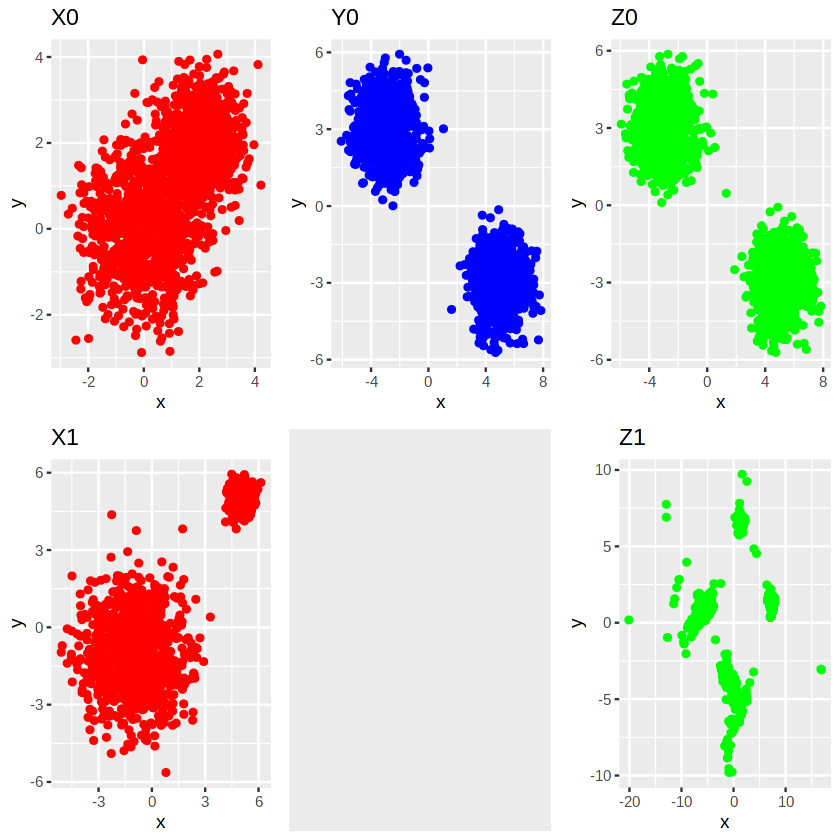

In [242]:
plot_2d( list( X0 = X0 , Y0 = Y0 , X1 = X1 , Z0 = Z0 , Z1 = Z1 ) )